# Handwritten text recognition - Final Assignment 
### Pedro Tavares de Carvalho
## Abstract
This notebook implements a Neural Network to recognize handwritten text. The network is composed of a Convolutional set, a LSTM step and a CTC loss step, which was based of several other similar papers, which will be referenced in the end of the Notebook. 

This notebook can also be found on my github page, by following [this link](https://github.com/ptcar2009/trabalho_ml). You can run it in Google Collaboratory by crating a new notebook and importing it from the github page mentioned above.
## Module installation
It uses the `pytorch` module for the building of the network, and the `cv2` for image input and processing. For the CTC decoding, the model uses the implementation from [this repository](https://github.com/parlance/ctcdecode). To install all dependencies, run the next cell from a Debian linux distribution, or from Google Colab. 

In [38]:
import cv2
import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt 
import os
from torch.utils.data import Dataset

## Data
The training data for this network is the IAM Handwriting Dataset, a compilation of several documents by many writers which is available for download at [this website](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database). The whole file structure is like this:

    -> Author
        -> Form
            -> Line
                -> Word
                
The images in the dataset have various formats, variyng in width and height. The maximum for both is `(128, 32)`, respectively. As a refularization for the input on the network, the images were ligned right and scaled, with no distortion, to fit on a `(128,32)` canvas. Whenever there is leftover space, it's filled with white padding to have a consistent size.

In [2]:
def formatImage(image):
    x_size, y_size = (128, 32) # the desired size
    y_cur_size, x_cur_size = image.shape # the current shape of the image
                                         # x and y are inverted in the input
        
    max_ratio = max(x_cur_size / x_size, y_cur_size / y_size) # figuring out the maximum ratio
                                                              # between original size and desired size
                                                              # from both axes
    x_cur_size, y_cur_size = (
        min(x_size, int(x_cur_size / max_ratio)), 
        min(y_size, int(y_cur_size / max_ratio)))
        # the new size is gonna be the maximum size within both constraints, of width and height
    
    image = cv2.resize(image, (x_cur_size, y_cur_size)) # resizing the image
    
    back = np.ones((y_size, x_size)) # filling up a (128, 32) space with white pixels
    
    back[:y_cur_size, :x_cur_size] = image # putting the image on top of the white space
    return back

The file structure, as stated earlier, is consistent throughout the whole dataset, easiyng the load up.

In [48]:
image_path = os.getcwd() +'/data/words/'
ground_truth_path = os.getcwd() + '/data/ascii/words.txt'

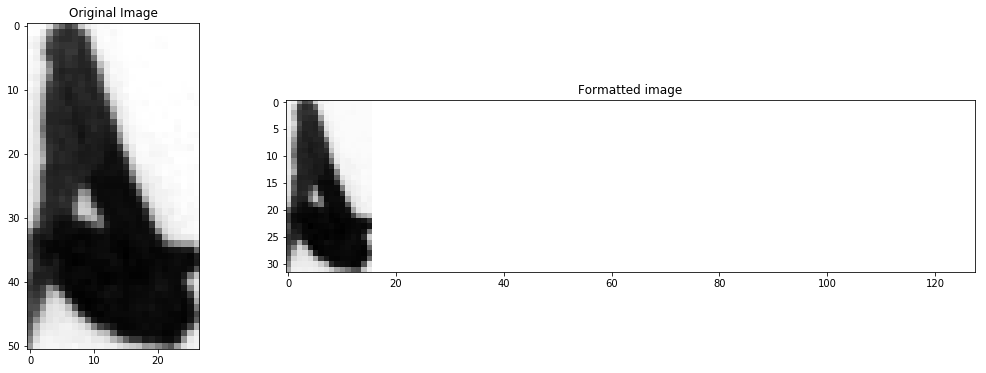

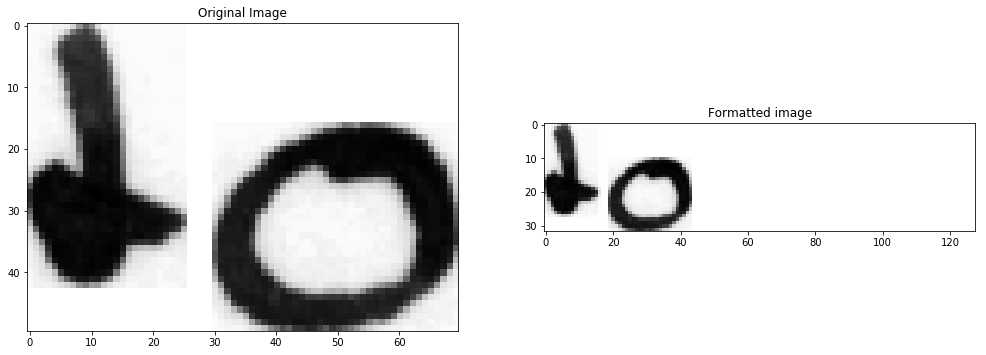

In [30]:
image = cv2.imread("/home/ptcar2009/Documents/UFMG/ML/TRABALHO/trabalho_ml/data/words/a01/a01-000u/a01-000u-00-00.png", cv2.IMREAD_GRAYSCALE)
image = image / 255
f, (axe1, axe2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize= (17,10))
axe1.set_title('Original Image')
axe1.imshow(image, cmap='gray')
image = formatImage(image)
axe2.set_title('Formatted image')
axe2.imshow(image, cmap='gray')
plt.show()

#
image = cv2.imread("/home/ptcar2009/Documents/UFMG/ML/TRABALHO/trabalho_ml/data/words/a01/a01-000u/a01-000u-00-02.png", cv2.IMREAD_GRAYSCALE)
image = image / 255
f, (axe1, axe2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize= (17,10))
axe1.set_title('Original Image')
axe1.imshow(image, cmap='gray')
image = formatImage(image)
axe2.set_title('Formatted image')
axe2.imshow(image, cmap='gray')
plt.show()


In [44]:
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
def LoadData():
    "Function to load data from the IAM dataset"
    data = []
    with open(ground_truth_path) as gt_file: # for each line in the ground truth file,
                                             # whitch contains the trascripts for the words
        for cur_img, line in enumerate(gt_file): # enumarate them
            
            if cur_img % 500 == 0: #log every 500
                print('Imagem {}'.format(cur_img))
                
            if line[0] != '#': # strip out comments
                parts = line.strip().split() # separate the lines in the specified format
                
                split_info = parts[0].split('-') # separate the word classification
                                                 # in pre determined segments
                    
                full_image_path = image_path + '/' + split_info[0] + '/' + '/'.join(
                    ['-'.join(split_info[: 1 + i]) for i in range(1, len(split_info)) if i != 2])
                                        # constructing the full image path, whitch is 
                                        # image_path/form/line/word.png
                        
                if parts[1] != 'ok': # if the word is invalid
                    continue
                    
                transcript = split_info[-1] # the last part of the input is the transcript
                
                try:
                    image = cv2.imread(full_image_path + '.png', 0) # read image
                    image = image / 255                            # normalize it
                except Exception as exception:
                    print(exception) # print errors that occur
                    continue
                
                image = formatImage(image) # formatting image
                data += [(transcript, image)] # Adding image to data
    return data

In [45]:
saved_data_path = '/data/saved_data/'

In [46]:
class Loader(Dataset):
    def __init__(self):
        self.img_size = (128, 32)
        saved_file = saved_data_path + 'pt'
        if (os.path.isfile(saved_file)):
            self.data = torch.load(saved_file)
        else:
            self.data = LoadData()
            torch.save(self.data, saved_file)

    def __getitem__(self, i):
        return self.data[i]

    def __len__(self):
        return len(self.data)

In [49]:
data = Loader()

Imagem 0
Imagem 500
Imagem 1000
Imagem 1500
Imagem 2000
Imagem 2500
Imagem 3000
Imagem 3500
Imagem 4000
unsupported operand type(s) for /: 'NoneType' and 'int'
Imagem 4500
Imagem 5000
Imagem 5500
Imagem 6000
Imagem 6500
Imagem 7000
Imagem 7500
Imagem 8000
Imagem 8500
Imagem 9000
Imagem 9500
Imagem 10000
Imagem 10500
Imagem 11000
Imagem 11500
Imagem 12000
Imagem 12500
Imagem 13000
Imagem 13500
Imagem 14000
Imagem 14500
Imagem 15000


KeyboardInterrupt: 